In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

from config import bls_api_key

In [98]:
# Create Series list for all states
series_list = []
for i in range(56):
    if i+1 <= 9:
        series_list.append(f"LASST0{i+1}0000000000003")
    elif i+1 >= 10:
        series_list.append(f"LASST{i+1}0000000000003")

series_list_2 = series_list[50:]
series_list_2

['LASST510000000000003',
 'LASST520000000000003',
 'LASST530000000000003',
 'LASST540000000000003',
 'LASST550000000000003',
 'LASST560000000000003']

In [100]:
state = []
unemployment_rate = []

for series in [series_list, series_list_2]: 
    default_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
    params = {
        'seriesid':series,
        'registrationkey':bls_api_key,
        'catalog':True,
        'startyear':'2018',
        'endyear':'2018',
        'calculations':True,
        'annualaverage':True
    }

    headers = {'Content-type': 'application/json'}
    data = json.dumps(params)
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    
    for i in range(len(series_list)):
        try:
            state.append(json_data['Results']['series'][i]['catalog']['area'])
            unemployment_rate.append(json_data['Results']['series'][i]['data'][0]['value'])
        except:
            print(f"Can not get info for series: {series_list[i]}")


1
2
Can not get info for series: LASST030000000000003
2
3
4
5
Can not get info for series: LASST070000000000003
5
6
7
8
9
10
11
Can not get info for series: LASST140000000000003
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Can not get info for series: LASST430000000000003
39
40
41
42
43
44
45
46
Can not get info for series: LASST510000000000003
46
Can not get info for series: LASST520000000000003
46
Can not get info for series: LASST530000000000003
46
Can not get info for series: LASST540000000000003
46
Can not get info for series: LASST550000000000003
46
Can not get info for series: LASST560000000000003
46
47
Can not get info for series: LASST020000000000003
47
48
49
50
51
Can not get info for series: LASST070000000000003
51
Can not get info for series: LASST080000000000003
51
Can not get info for series: LASST090000000000003
51
Can not get info for series: LASST100000000000003
51
Can not get info for series: LASST110000000000003
51
Can not ge

In [74]:
print(json_data['Results']['series'][1]['catalog']['area'])
print(json_data['Results']['series'][0]['data'][0].keys())
print(json_data['Results']['series'][0]['data'][0]['value'])

Alaska
dict_keys(['year', 'period', 'periodName', 'value', 'footnotes', 'calculations'])
3.8


In [116]:
# Create data frame
unemployment_data = pd.DataFrame({'unemployment_rate':unemployment_rate}, index=state)
unemployment_data.reset_index(inplace=True)
unemployment_data.columns = ['State','unemployment_rate']
unemployment_data['unemployment_rate'] = unemployment_data['unemployment_rate'].astype(float)
unemployment_data.head()

# Export to CSV to save on API calls
unemployment_data.to_csv('./output/unemployment_rates_by_state.csv', index=False)

In [112]:
unemployment_data['unemployment_rate'].describe()

count    51.000000
mean      3.735294
std       0.841861
min       2.400000
25%       3.100000
50%       3.700000
75%       4.250000
max       6.500000
Name: unemployment_rate, dtype: float64

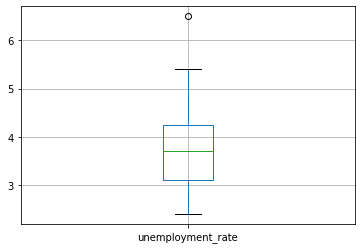

In [113]:
# Graph
unemployment_data.boxplot('unemployment_rate')

In [114]:
# Get outlier
unemployment_data[unemployment_data['unemployment_rate'] == 6.5]

,State,unemployment_rate
1,Alaska,6.5


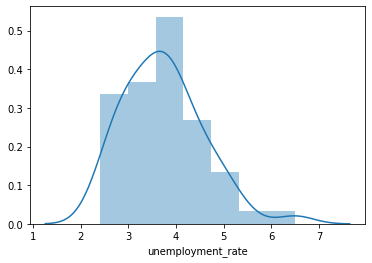

In [115]:
sns.distplot(unemployment_data['unemployment_rate'])

### State and County Wages
(Quarterly Census of Employment & Wages - QCEW)

In [368]:
# Import table mapping series to county, state for use in API data pull
county_index = pd.read_csv('./data/area_titles.csv')
county_index.head()

,area_fips,area_title
0,1000,Alabama -- Statewide
1,1001,"Autauga County, Alabama"
2,1003,"Baldwin County, Alabama"
3,1005,"Barbour County, Alabama"
4,1007,"Bibb County, Alabama"


In [369]:
# Separate County name and State name
def split_state_county(s,index):
    if len(s.split(",")) > 1:
        return s.split(",")[index].strip()

county_index['County'] = county_index['area_title'].apply(split_state_county, args=(0,))
county_index['State'] = county_index['area_title'].apply(split_state_county, args=(1,))

# Drop area_title
county_index.drop('area_title',axis=1,inplace=True)



In [370]:
county_index.info()
county_index = county_index.dropna()
county_index.info()
county_index.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3515 entries, 0 to 3514
Data columns (total 3 columns):
area_fips    3515 non-null int64
County       3405 non-null object
State        3405 non-null object
dtypes: int64(1), object(2)
memory usage: 82.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405 entries, 1 to 3514
Data columns (total 3 columns):
area_fips    3405 non-null int64
County       3405 non-null object
State        3405 non-null object
dtypes: int64(1), object(2)
memory usage: 106.4+ KB


,area_fips,County,State
1,1001,Autauga County,Alabama
2,1003,Baldwin County,Alabama
3,1005,Barbour County,Alabama
4,1007,Bibb County,Alabama
5,1009,Blount County,Alabama


In [371]:
# Join with Master dataset to reduce the number of API calls
master = pd.read_csv('./output/master_data.csv')
master = master[['State','County']]
master.head(10)

,State,County
0,Florida,Miami-Dade County
1,California,Stanislaus County
2,Oregon,Multnomah County
3,Texas,Dallas County
4,California,Orange County
5,California,Orange County
6,California,Orange County
7,Iowa,Linn County
8,Connecticut,New Haven County
9,Washington,King County


In [372]:
# Drop duplicates from master
master_deduped = master.drop_duplicates(['State','County'])
master_deduped.head(10)

,State,County
0,Florida,Miami-Dade County
1,California,Stanislaus County
2,Oregon,Multnomah County
3,Texas,Dallas County
4,California,Orange County
7,Iowa,Linn County
8,Connecticut,New Haven County
9,Washington,King County
10,Virginia,Hampton City
11,Virginia,Virginia Beach City


In [373]:
# Set indexes
county_index_for_join = county_index.set_index(['State','County'])
master_deduped = master_deduped.set_index(['State','County'])

# Perform join
county_index_filtered = master_deduped.join(county_index_for_join, how='inner')
county_index_filtered.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 159 entries, (Alabama, Jefferson County) to (Wisconsin, Milwaukee County)
Data columns (total 1 columns):
area_fips    159 non-null int64
dtypes: int64(1)
memory usage: 3.4+ KB


In [374]:
counties = county_index_filtered.reset_index()
counties.head()
counties.tail()

,State,County,area_fips
154,Washington,King County,53033
155,Washington,Pierce County,53053
156,Washington,Snohomish County,53061
157,Wisconsin,Dane County,55025
158,Wisconsin,Milwaukee County,55079


In [375]:
len(series_list)

159

In [299]:
series_list=[]
for area_code in counties['area_fips']:
    if len(str(area_code)) < 5:
        series_list.append(f"ENU0{area_code}10010")
    else:
        series_list.append(f"ENU{area_code}10010")
series_list

# API only allows for up to 50 calls at once -- will split call
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

for i in chunks(series_list,40):
    print(i)

['ENU0107310010', 'ENU0109710010', 'ENU0110110010', 'ENU0112510010', 'ENU0401310010', 'ENU0401910010', 'ENU0511910010', 'ENU0600110010', 'ENU0601310010', 'ENU0601910010', 'ENU0602910010', 'ENU0603710010', 'ENU0605310010', 'ENU0605910010', 'ENU0606110010', 'ENU0606510010', 'ENU0606710010', 'ENU0607110010', 'ENU0607310010', 'ENU0607510010', 'ENU0607710010', 'ENU0608110010', 'ENU0608510010', 'ENU0609510010', 'ENU0609710010', 'ENU0609910010', 'ENU0611110010', 'ENU0800110010', 'ENU0800510010', 'ENU0801310010', 'ENU0803110010', 'ENU0804110010', 'ENU0805910010', 'ENU0806910010', 'ENU0810110010', 'ENU0900110010', 'ENU0900310010', 'ENU0900910010', 'ENU1200110010', 'ENU1201110010']
['ENU1203110010', 'ENU1205710010', 'ENU1208610010', 'ENU1209510010', 'ENU1209910010', 'ENU1210310010', 'ENU1302110010', 'ENU1312110010', 'ENU1321510010', 'ENU1500310010', 'ENU1600110010', 'ENU1703110010', 'ENU1704310010', 'ENU1708910010', 'ENU1714310010', 'ENU1716710010', 'ENU1720110010', 'ENU1800310010', 'ENU18097100

In [307]:
series_name = []
wage_data = [] # pct change over 12 month period

for series in chunks(series_list,40): 
    default_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
    params = {
        'seriesid':series,
        'registrationkey':bls_api_key,
        'catalog':True,
        'startyear':'2018',
        'endyear':'2018',
        'calculations':True,
        'annualaverage':True
    }

    headers = {'Content-type': 'application/json'}
    data = json.dumps(params)
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)
    
    for i in range(4):
        try:
            series_name.append(json_data['Results']['series'][i]['seriesID'])
            wage_data.append(json_data['Results']['series'][i]['data'][0]['calculations']['pct_changes']['12'])
        except:
            print(f"Can not get info for series: {series_list[i]}")


In [376]:
print(json_data)

{'status': 'REQUEST_SUCCEEDED', 'responseTime': 632, 'message': ['Unable to get Catalog Data for series ENU4609910010', 'Unable to get Catalog Data for series ENU4703710010', 'Unable to get Catalog Data for series ENU4714910010', 'Unable to get Catalog Data for series ENU4715710010', 'Unable to get Catalog Data for series ENU4802710010', 'Unable to get Catalog Data for series ENU4802910010', 'Unable to get Catalog Data for series ENU4803910010', 'Unable to get Catalog Data for series ENU4808510010', 'Unable to get Catalog Data for series ENU4811310010', 'Unable to get Catalog Data for series ENU4812110010', 'Unable to get Catalog Data for series ENU4814110010', 'Unable to get Catalog Data for series ENU4815710010', 'Unable to get Catalog Data for series ENU4816710010', 'Unable to get Catalog Data for series ENU4820110010', 'Unable to get Catalog Data for series ENU4821510010', 'Unable to get Catalog Data for series ENU4830310010', 'Unable to get Catalog Data for series ENU4830910010', 

In [311]:
with open('data.txt', 'w') as outfile:  
    json.dump(json_data, outfile)

In [314]:
len(series_name)

16

In [303]:
wage_data[:10]

['1.6', '0.6', '-0.8', '1.9', '3.4', '1.2', '2.4', '1.8', '1.9', '3.4']

In [377]:
wages = pd.DataFrame({
    'Series':series_name,
    'wages_2018_12mo_pct_chg':wage_data
})

wages['wages_2018_12mo_pct_chg'] = wages['wages_2018_12mo_pct_chg'].astype(float)
print(wages.shape)

# Export to CSV to save on API calls
wages.to_csv('./output/wages_2018_pct_chg_by_county.csv', index=False)

wages.head()

(159, 2)


,Series,wages_2018_12mo_pct_chg
0,ENU0107310010,1.6
1,ENU0109710010,0.6
2,ENU0110110010,-0.8
3,ENU0112510010,1.9
4,ENU0401310010,3.4


### Merge wages into working dataset to get county name

In [378]:
# Add Series column to Counties dataframe. Will be used as join key
counties['Series'] = series_list
counties.head()
counties.tail()

# Set index for join
counties_for_join = counties.set_index('Series')
wages_for_join = wages.set_index('Series')

full_wage_data = counties_for_join.join(wages_for_join, how='inner')

# Confirm join
print(full_wage_data.shape)
full_wage_data.head()

(159, 4)


,State,County,area_fips,wages_2018_12mo_pct_chg
Series,,,,
ENU0107310010,Alabama,Jefferson County,1073,1.6
ENU0109710010,Alabama,Mobile County,1097,0.6
ENU0110110010,Alabama,Montgomery County,1101,-0.8
ENU0112510010,Alabama,Tuscaloosa County,1125,1.9
ENU0401310010,Arizona,Maricopa County,4013,3.4


### Analysis of 2018 Wages (12 month pct change)

In [379]:
full_wage_data.wages_2018_12mo_pct_chg.describe()

count    159.000000
mean       1.595597
std        1.344014
min       -2.000000
25%        0.700000
50%        1.500000
75%        2.400000
max        6.200000
Name: wages_2018_12mo_pct_chg, dtype: float64

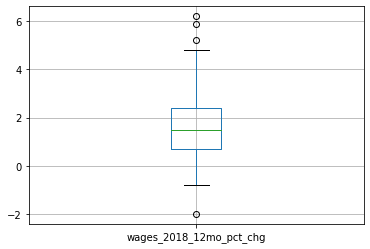

In [380]:
# Graph
full_wage_data.boxplot('wages_2018_12mo_pct_chg')

In [381]:
# Inspect high values
full_wage_data[['State','County','wages_2018_12mo_pct_chg']].sort_values(by='wages_2018_12mo_pct_chg',ascending=False)[:10]



,State,County,wages_2018_12mo_pct_chg
Series,,,
ENU3608110010,New York,Queens County,6.2
ENU4815710010,Texas,Fort Bend County,5.9
ENU4803910010,Texas,Brazoria County,5.2
ENU4849110010,Texas,Williamson County,4.8
ENU1600110010,Idaho,Ada County,4.8
ENU4714910010,Tennessee,Rutherford County,4.4
ENU0606110010,California,Placer County,4.3
ENU5170010010,Virginia,Newport News City,4.2
ENU4808510010,Texas,Collin County,4.2


In [382]:
# Inspect low values
full_wage_data[['State','County','wages_2018_12mo_pct_chg']].sort_values(by='wages_2018_12mo_pct_chg')[:10]

,State,County,wages_2018_12mo_pct_chg
Series,,,
ENU5151010010,Virginia,Alexandria City,-2.0
ENU0110110010,Alabama,Montgomery County,-0.8
ENU4837510010,Texas,Potter County,-0.8
ENU2106710010,Kentucky,Fayette County,-0.8
ENU2020910010,Kansas,Wyandotte County,-0.6
ENU1704310010,Illinois,DuPage County,-0.6
ENU4816710010,Texas,Galveston County,-0.6
ENU2606510010,Michigan,Ingham County,-0.4
ENU5165010010,Virginia,Hampton City,-0.4


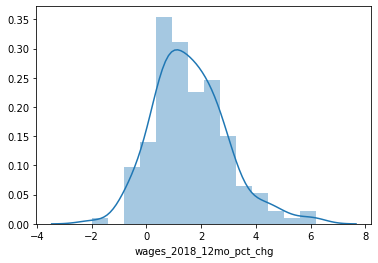

In [383]:
sns.distplot(full_wage_data['wages_2018_12mo_pct_chg'])